In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns

def evaluate_kmeans_clusters(df, max_k=10, random_state=42):
    """
    Evaluates KMeans clustering with multiple cluster counts (K),
    returns silhouette scores and inertia values.
    """
    df = df.copy()
    df.columns = df.columns.str.strip().str.lower()

    # Aggregate features
    features = (
        df.groupby('trade_code')
          .agg(
              mean_price=('price', 'mean'),
              std_price=('price', 'std'),
              mean_bookings=('bookings', 'mean'),
              std_bookings=('bookings', 'std')
          )
    )

    X = features[['mean_price', 'std_price', 'mean_bookings', 'std_bookings']]
    X_scaled = StandardScaler().fit_transform(X)

    silhouette_scores = []
    inertias = []
    k_values = list(range(2, max_k + 1))

    for k in k_values:
        model = KMeans(n_clusters=k, random_state=random_state)
        labels = model.fit_predict(X_scaled)

        sil_score = silhouette_score(X_scaled, labels)
        silhouette_scores.append(sil_score)
        inertias.append(model.inertia_)

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(k_values, silhouette_scores, marker='o')
    ax[0].set_title("Silhouette Score by Number of Clusters")
    ax[0].set_xlabel("Number of Clusters (k)")
    ax[0].set_ylabel("Silhouette Score")
    ax[0].grid(True)

    ax[1].plot(k_values, inertias, marker='o')
    ax[1].set_title("Inertia (WCSS) by Number of Clusters")
    ax[1].set_xlabel("Number of Clusters (k)")
    ax[1].set_ylabel("Inertia")
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

    return pd.DataFrame({
        'k': k_values,
        'silhouette_score': silhouette_scores,
        'inertia': inertias
    })


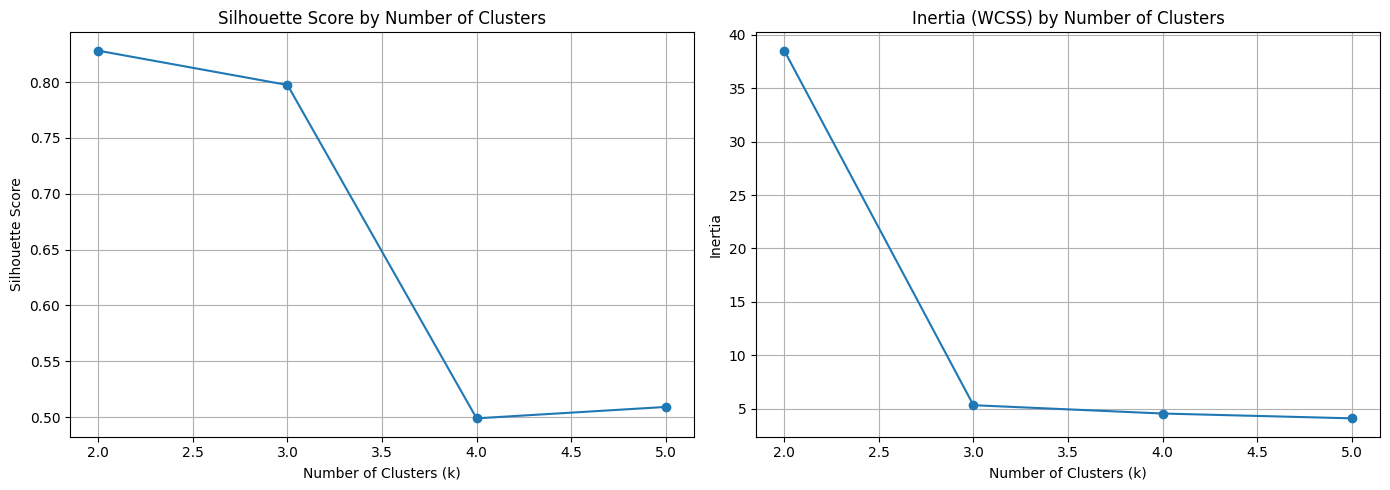

In [6]:
df = pd.read_csv("pricing_treatment.csv")
results = evaluate_kmeans_clusters(df, max_k=5)


In [9]:
def cluster_by_price_and_bookings(df, n_clusters=4, plot=True, random_state=42, rank_by='avg_revenue'):
    """
    Cluster trade codes based on price and booking patterns.
    Also evaluates and ranks clusters based on average revenue or other KPIs.

    Parameters:
    - df: raw DataFrame with 'trade_code', 'price', 'bookings'
    - n_clusters: number of clusters
    - plot: whether to visualize the cluster scatterplot
    - random_state: random seed
    - rank_by: metric to rank clusters by ('avg_revenue', 'mean_bookings', 'mean_price', etc.)

    Returns:
    - clustered_df: DataFrame with cluster labels and performance
    - cluster_scores: DataFrame with ranked clusters
    """
    df = df.copy()
    df.columns = df.columns.str.strip().str.lower()

    # Step 1: Trade-level aggregation
    summary_df = (
        df.groupby('trade_code')
          .agg(
              mean_price=('price', 'mean'),
              std_price=('price', 'std'),
              mean_bookings=('bookings', 'mean'),
              std_bookings=('bookings', 'std')
          )
    )

    # Derived metric: average revenue
    summary_df['avg_revenue'] = summary_df['mean_price'] * summary_df['mean_bookings']

    # Step 2: Clustering
    features = summary_df[['mean_price', 'std_price', 'mean_bookings', 'std_bookings']]
    scaler = StandardScaler()
    scaled = scaler.fit_transform(features)

    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    summary_df['cluster'] = kmeans.fit_predict(scaled)

    # Step 3: Cluster performance summary
    cluster_scores = (
        summary_df.groupby('cluster')
                  .agg(
                      avg_price=('mean_price', 'mean'),
                      avg_bookings=('mean_bookings', 'mean'),
                      avg_std_price=('std_price', 'mean'),
                      avg_std_bookings=('std_bookings', 'mean'),
                      avg_revenue=('avg_revenue', 'mean'),
                      num_trades=('mean_price', 'count')
                  )
                  .sort_values(by=rank_by, ascending=False)
                  .reset_index()
    )

    # Add rank
    cluster_scores['rank'] = cluster_scores[rank_by].rank(method='dense', ascending=False).astype(int)

    # Optional plot
    if plot:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            data=summary_df,
            x='std_price',
            y='std_bookings',
            hue='cluster',
            palette='tab10',
            s=100
        )
        plt.title(f"Clusters of Trades (n={n_clusters})")
        plt.xlabel("STD Price")
        plt.ylabel("STD Bookings")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return summary_df.reset_index(), cluster_scores


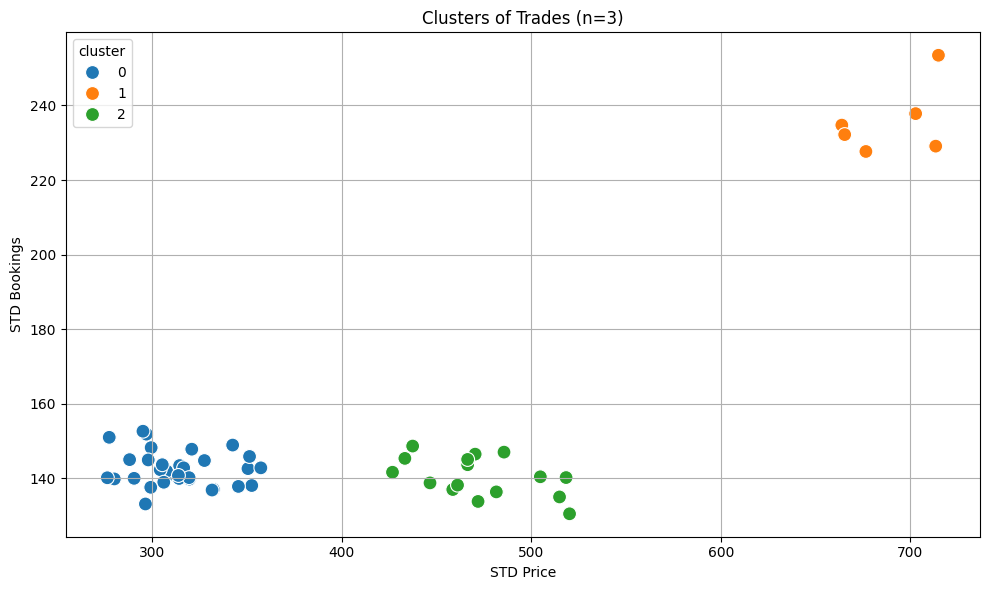

In [10]:
clustered_df, cluster_scores = cluster_by_price_and_bookings(df, n_clusters=3)


In [9]:
clustered_df

,trade_code,mean_price,std_price,mean_bookings,std_bookings,avg_revenue,cluster
0,A1,2018.596278,299.498957,212.766667,148.273004,4.294900e+05,0
1,A6,1935.899556,290.510272,208.033333,140.039536,4.027316e+05,0
2,A7,3116.396278,466.483453,206.233333,143.688175,6.427048e+05,2
3,A8,3028.818278,470.440744,207.527778,146.522461,6.285639e+05,2
4,B2,4706.266611,676.607713,326.933333,227.658021,1.538635e+06,1
5,C2,2935.327833,446.625163,202.794444,138.811141,5.952682e+05,2
6,C3,3124.936000,458.643904,202.611111,137.035305,6.331468e+05,2
7,C4,2012.688111,311.046867,208.672222,141.145942,4.199921e+05,0
8,C6,3074.235444,504.831969,200.905556,140.449625,6.176310e+05,2
9,D5,4656.074444,663.901246,321.300000,234.724298,1.495997e+06,1
